In [3]:
import os
import glob
import uproot
import awkward as ak
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.optimize import curve_fit
import mplhep as hep
plt.style.use(hep.style.CMS)
import yahist
from tqdm import tqdm

plt.rcParams.update({"figure.facecolor": (1,1,1,0)})

PLOTS_DIR = "/home/users/jguiang/public_html/lhe_plots/vbswh"
os.makedirs(PLOTS_DIR, exist_ok=True)

In [4]:
def get_lhe_df(input_dir, lumi_invfb=138):
    """
    Extract kinematics, etc. from LHE files converted to ROOT files by utils/leshouche.py
    """
    dfs = []
    for root_file in tqdm(glob.glob(input_dir)):
        kW, kZ = (-999, -999)
        name = root_file.split("/")[-1].replace("_Inclusive_4f_LO.root", "")
        if name == "VBSWH":
            kW, kZ = (1, 1)
        elif name == "VBSWH_mkW":
            kW, kZ = (-1, 1)
        elif name == "VBSWH_mkZ":
            kW, kZ = (1, -1)
        elif "kW" in name:
            kZ = 1
            kW = float(name.replace("VBSWH_", "").replace("m", "-").replace("p", ".").replace("kW", ""))
        elif "kZ" in name:
            kW = 1
            kZ = float(name.replace("VBSWH_", "").replace("m", "-").replace("p", ".").replace("kZ", ""))
        else:
            raise Exception(f"unable to parse {root_file} for kW, kZ values!")

        with uproot.open(root_file) as f:
            # Extract kinematics df
            df = f["Events"].arrays(library="pd").reset_index(level=[0,1])
            # Calculate pT
            df["P_T"] = np.sqrt(df.P_X**2 + df.P_Y**2)
            # Calculate cross section scale factor
            xsec_pb = f["Processes"].arrays()[0]["XSECUP"]
            df["xsec_sf"] = (1000*xsec_pb*lumi_invfb)/len(df)
            df["kW"] = kW
            df["kZ"] = kZ

            # Require that it is VBSWH (pp -> WHqq):
            #     other processes have extra particles that come from W, H, or one of the VBS q's, 
            #     so we can reject any event that has a particle whose mother is not the first or 
            #     second particle, i.e. the incoming partons
            df = df[~np.isin(df.entry, df[df.MOTHUP1 > 1].entry.unique())]

            dfs.append(df)

    return pd.concat(dfs)
    
df = get_lhe_df("/ceph/cms/store/user/jguiang/VBSWHSignalGeneration/lhe/new_vbswh_singlepoint/*.root")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:37<00:00,  1.76s/it]


In [5]:
def get_ST_hist(df, kW, kZ, bins, norm=False):
    # Get mask for kW, kZ point
    kWkZ = (df.kW == kW) & (df.kZ == kZ)
    # Get W, H pT
    W_pt = df[kWkZ & (df.IDUP.abs() == 24)].P_T.values
    H_pt = df[kWkZ & (df.IDUP.abs() == 25)].P_T.values
    # Get events weights
    wgts = df[kWkZ & (df.IDUP.abs() == 24)].xsec_sf.values
    # Get histogram
    hist = yahist.Hist1D(W_pt + H_pt, bins=bins, weights=wgts)
    if norm:
        return hist.normalize()
    else:
        return hist

def get_M_WH_hist(df, kW, kZ, bins, norm=False):
    # Get mask for kW, kZ point
    kWkZ = (df.kW == kW) & (df.kZ == kZ)
    # Get W 4-vector
    W_px = df[kWkZ & (df.IDUP.abs() == 24)].P_X.values
    W_py = df[kWkZ & (df.IDUP.abs() == 24)].P_Y.values
    W_pz = df[kWkZ & (df.IDUP.abs() == 24)].P_Z.values
    W_E  = df[kWkZ & (df.IDUP.abs() == 24)].E.values
    # Get H 4-vector
    H_px = df[kWkZ & (df.IDUP.abs() == 25)].P_X.values
    H_py = df[kWkZ & (df.IDUP.abs() == 25)].P_Y.values
    H_pz = df[kWkZ & (df.IDUP.abs() == 25)].P_Z.values
    H_E  = df[kWkZ & (df.IDUP.abs() == 25)].E.values
    # Calculate components of invariant mass
    WH_P2 = (W_px + H_px)**2 + (W_py + H_py)**2 + (W_pz + H_pz)**2
    WH_E2 = ( W_E + H_E )**2
    # Get event weights
    wgts = df[kWkZ & (df.IDUP.abs() == 24)].xsec_sf.values
    # Get histogram
    hist = yahist.Hist1D(np.sqrt(WH_E2 - WH_P2), bins=bins, weights=wgts)
    if norm:
        return hist.normalize()
    else:
        return hist

def plot_var(var, bins, norm=True):
    print(f"Plotting {var} for a selection of kW, kZ points...")
    if var == "ST":
        get_hist = lambda kW, kZ, bins: get_ST_hist(df, kW, kZ, bins, norm=norm)
    elif var == "M_WH":
        get_hist = lambda kW, kZ, bins: get_M_WH_hist(df, kW, kZ, bins, norm=norm)
    else:
        raise Exception(f"{var} not supported")
        
    # Get SM hist
    sm_hist = get_hist(1, 1, bins)
    
    # Plot other points
    kV_points = [0.0, -0.5, -1.5]
    kV_styles = [
        {"color": "#6ea5cd", "errors": True, "fmt": "s"}, # 0.0
        {"color": "#feda8a", "errors": True, "fmt": "o"}, # -0.5
        {"color": "#dd3c2d", "errors": True, "fmt": "^"}, # -1.5
    ]
    for V in ["W", "Z"]:
            
        # --- Set up plot with only SM and mkV points ---
        fig = plt.figure()
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
        hist_axes = fig.add_subplot(gs[0])
        ratio_axes = fig.add_subplot(gs[1])
        
        # Plot SM
        sm_hist.plot(ax=hist_axes, color="#364b9a", label="SM", histtype="stepfilled")
        # Plot mkVs
        mkW_hist = get_hist(-1, 1, bins)
        mkW_hist.plot(
            ax=hist_axes, color="#f67e4b", hatch="/////",
            label=r"$\kappa_W = -1$, $\kappa_Z = +1$"
        )
        mkZ_hist = get_hist(1, -1, bins)
        mkZ_hist.plot(
            ax=hist_axes, color="#97cae1", hatch="\\\\",
            label=r"$\kappa_W = +1$, $\kappa_Z = -1$"
        )
        # Plot mkV/SM ratios
        (mkW_hist/sm_hist).plot(ax=ratio_axes, errors=True, color="#f67e4b", zorder=1.2, fmt=" ")
        (mkZ_hist/sm_hist).plot(ax=ratio_axes, errors=True, color="#97cae1", zorder=1.2, fmt=" ")
        
        # Format axes
        hist_axes.set_xticklabels([])
        # Add CMS label
        hep.cms.label(
            "Preliminary",
            data=False,
            loc=0,
            ax=hist_axes,
        )
        if var == "ST":
            ratio_axes.set_xlabel(r"$p_{T, H} + p_{T, W}$ [GeV]");
        elif var == "M_WH":
            ratio_axes.set_xlabel(r"$M_{WH}$ [GeV]");

        ratio_axes.set_ylabel(r"$(\kappa_V = -1)/SM$", size=18, horizontalalignment="center")
        ratio_axes.set_yscale("log");
        
        outfile = f"{PLOTS_DIR}/lhe_{var}_mkW_mkZ.pdf"
        if norm:
            outfile = outfile.replace(".pdf", "_norm.pdf")
        plt.savefig(outfile)
        plt.savefig(outfile.replace(".pdf", ".png"))
        plt.close()
        print(f"Wrote {outfile}")
        
        # --- Set up plot with more kW, kZ points ---
        fig = plt.figure()
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
        hist_axes = fig.add_subplot(gs[0])
        ratio_axes = fig.add_subplot(gs[1])
        
        if V == "W":
            kWkZ_points = zip(kV_points, [1.0 for _ in kV_points])
            mkV_hist = get_hist(-1, 1, bins)
        elif V == "Z":
            kWkZ_points = zip([1.0 for _ in kV_points], kV_points)
            mkV_hist = get_hist(1, -1, bins)
        
        # Plot kV = -1
        mkV_hist.plot(
            ax=hist_axes, color="#f67e4b", hatch="/////", zorder=102,
            label=r"$\kappa_V = -1$".replace("V", V)
        )
        # Plot (kV = -1)/SM ratio
        ratio_hist = mkV_hist/sm_hist
        ratio_hist.plot(ax=ratio_axes, errors=True, color="#f67e4b", zorder=1.2, fmt=" ")
            
        for kWkZ_i, (kW, kZ) in enumerate(kWkZ_points):
            hist = get_hist(kW, kZ, bins)
            if V == "W":
                label = r"$\kappa_W = KW$".replace("KW", str(kW))
            elif V == "Z":
                label = r"$\kappa_Z = KZ$".replace("KZ", str(kZ))
                
            hist.plot(ax=hist_axes, label=label, **kV_styles[kWkZ_i], zorder=102+kWkZ_i)

        # Plot legend
        hist_axes.legend(title=r"$\kappa_V = 1$".replace("V", "Z" if V == "W" else "W"));
        # Change axis labels
        hist_axes.set_ylabel("a.u.")
        hist_axes.set_xticklabels([])
        # Add CMS label
        hep.cms.label(
            "Preliminary",
            data=False,
            loc=0,
            ax=hist_axes,
        )
        if var == "ST":
            ratio_axes.set_xlabel(r"$p_{T, H} + p_{T, W}$ [GeV]");
        elif var == "M_WH":
            ratio_axes.set_xlabel(r"$M_{WH}$ [GeV]");

        ratio_axes.set_ylabel(r"$(\kappa_V = -1)/SM$".replace("V", V), size=18, horizontalalignment="center")
        ratio_axes.set_yscale("log");
        
        if V == "W":
            outfile = f"{PLOTS_DIR}/lhe_{var}_1p0kZ_kWpoints_noPosLambda.pdf"
        elif V == "Z":
            outfile = f"{PLOTS_DIR}/lhe_{var}_1p0kW_kZpoints_noPosLambda.pdf"
        if norm:
            outfile = outfile.replace(".pdf", "_norm.pdf")
            
        plt.savefig(outfile)
        plt.savefig(outfile.replace(".pdf", ".png"))
        print(f"Wrote {outfile}")
        
        # Plot kV = 0.5
        if V == "W":
            get_hist(0.5, 1.0, bins).plot(
                ax=hist_axes, color="#97cae1", hatch="\\\\", zorder=101,
                label=r"$\kappa_W = 0.5$".replace("V", V)
            )
        elif V == "Z":
            get_hist(0.5, 1.0, bins).plot(
                ax=hist_axes, color="#97cae1", hatch="\\\\", zorder=101,
                label=r"$\kappa_Z = 0.5$".replace("V", V)
            )
        # Plot legend
        hist_axes.legend(title=r"$\kappa_V = 1$".replace("V", "Z" if V == "W" else "W"));
        # Save plot
        outfile = outfile.replace("_noPosLambda", "_noSM")
        plt.savefig(outfile)
        plt.savefig(outfile.replace(".pdf", ".png"))
        print(f"Wrote {outfile}")
        
        # Plot SM
        sm_hist.plot(ax=hist_axes, color="#364b9a", label="SM", histtype="stepfilled", zorder=100)
        # Plot legend
        hist_axes.legend(title=r"$\kappa_V = 1$".replace("V", "Z" if V == "W" else "W"));
        # Save plot
        outfile = outfile.replace("_noSM", "")
        plt.savefig(outfile)
        plt.savefig(outfile.replace(".pdf", ".png"))
        plt.close()
        print(f"Wrote {outfile}")

def get_reco_hist(kW, kZ, var, bins, breakdown_hists=None):
    if breakdown_hists is None:
        if var == "ST":
            SM_hist  = get_ST_hist(df, 1, 1, bins)
            kZ0_hist = get_ST_hist(df, 1, 0, bins)
            kW0_hist = get_ST_hist(df, 0, 1, bins)
        elif var == "M_WH":
            SM_hist  = get_M_WH_hist(df, 1, 1, bins)
            kZ0_hist = get_M_WH_hist(df, 1, 0, bins)
            kW0_hist = get_M_WH_hist(df, 0, 1, bins)
    else:
        SM_hist, kZ0_hist, kW0_hist = breakdown_hists
    
    return (kW**2)*kZ0_hist + (kW*kZ)*(SM_hist - kW0_hist - kZ0_hist) + (kZ**2)*kW0_hist
        
def plot_breakdown(kW, kZ, var, bins, breakdown_hists=None, norm=False, save=True):
        if breakdown_hists is None:
            if var == "ST":
                SM_hist  = get_ST_hist(df, 1, 1, bins)
                kZ0_hist = get_ST_hist(df, 1, 0, bins)
                kW0_hist = get_ST_hist(df, 0, 1, bins)
            elif var == "M_WH":
                SM_hist  = get_M_WH_hist(df, 1, 1, bins)
                kZ0_hist = get_M_WH_hist(df, 1, 0, bins)
                kW0_hist = get_M_WH_hist(df, 0, 1, bins)
        else:
            SM_hist, kZ0_hist, kW0_hist = breakdown_hists
            
        # Get "real" histogram
        if var == "ST":
            real_hist = get_ST_hist(df, kW, kZ, bins)
        elif var == "M_WH":
            real_hist = get_M_WH_hist(df, kW, kZ, bins)
            
        # Set up hist/ratio
        fig = plt.figure()
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
        hist_axes = fig.add_subplot(gs[0])
        ratio_axes = fig.add_subplot(gs[1])

        # Plot reconstructed hist
        reco_hist = get_reco_hist(kW, kZ, var, bins, breakdown_hists=(SM_hist, kZ0_hist, kW0_hist))
        if norm:
            reco_hist /= real_hist.integral
        reco_hist.plot(
            ax=hist_axes, histtype="stepfilled", alpha=0.25, 
            label="$\kappa_W^2 A_W + \kappa_W\kappa_Z A_{WZ} + \kappa_Z^2 A_Z$"
        )
        # Plot components of reconstructed hist
        kW2AW_hist = (kW**2)*kZ0_hist
        if norm:
            kW2AW_hist /= real_hist.integral
        kW2AW_hist.plot(
            ax=hist_axes, label=r"$\kappa_W^2 A_W$", linestyle="dashed"
        )
        kZ2AZ_hist = ((kZ**2)*kW0_hist)
        if norm:
            kZ2AZ_hist /= real_hist.integral
        kZ2AZ_hist.plot(
            ax=hist_axes, label=r"$\kappa_Z^2 A_Z$", linestyle="dotted"
        )
        kWkZAWZ_hist = (kW*kZ)*(SM_hist - kW0_hist - kZ0_hist)
        if norm:
            kWkZAWZ_hist /= real_hist.integral
        kWkZAWZ_hist.plot(
            ax=hist_axes, label=r"$\kappa_W\kappa_Z A_{WZ}$", linestyle="dashdot"
        )
        hist_axes.axhline(y=0, color="k", alpha=0.25)

        # Plot real hist
        if norm:
            real_hist = real_hist.normalize()
        real_hist.plot(ax=hist_axes, label="Actual", errors=True)

        # Plot reco/real ratio
        ratio_hist = reco_hist/real_hist
        ratio_hist.plot(ax=ratio_axes, errors=True, zorder=1.2, fmt=" ")
        ratio_axes.axhline(y=1, color="grey", linestyle="--")

        # Format axes
        hist_axes.set_xticklabels([])
        if norm:
            hist_axes.set_ylabel("a.u.")
        else:
            hist_axes.set_ylabel("Events")
        ratio_axes.set_ylim([0.5, 1.5])
        if var == "ST":
            ratio_axes.set_xlabel(r"$p_{T, H} + p_{T, W}$ [GeV]")
        elif var == "M_WH":
            ratio_axes.set_xlabel(r"$M_{WH}$ [GeV]")

        # Add CMS label
        hep.cms.label("Preliminary", data=False, loc=0, ax=hist_axes)

        # Add legend
        hist_axes.legend(loc="upper right", fontsize=18)

        # Add kW and kZ label
        hist_axes.text(
            0.97, 0.03,
            r"$\kappa_W = KW$, $\kappa_Z = KZ$".replace("KW", str(kW)).replace("KZ", str(kZ)),
            ha="right", va="bottom",
            transform = hist_axes.transAxes
        )

        # Save plot
        if save:
            outfile = (
                f"{PLOTS_DIR}/lhe_{var}_breakdown_KWkW_KZkZ.pdf".replace("KW", f"{kW:.1f}".replace("-", "m").replace(".", "p"))
                                                                .replace("KZ", f"{kZ:.1f}".replace("-", "m").replace(".", "p"))
            )
            if norm:
                outfile = outfile.replace(".pdf", "_norm.pdf")
            plt.savefig(outfile, bbox_inches="tight")
            plt.savefig(outfile.replace(".pdf", ".png"), bbox_inches="tight")
            print(f"Wrote {outfile}")
            plt.close()
        
        return reco_hist

def plot_all(var, bins, norm=False):
    
    plot_var(var, bins, norm=norm)
    
    # Get histograms for breakdown
    if var == "ST":
        SM_hist  = get_ST_hist(df, 1, 1, bins)
        kZ0_hist = get_ST_hist(df, 1, 0, bins)
        kW0_hist = get_ST_hist(df, 0, 1, bins)
    elif var == "M_WH":
        SM_hist  = get_M_WH_hist(df, 1, 1, bins)
        kZ0_hist = get_M_WH_hist(df, 1, 0, bins)
        kW0_hist = get_M_WH_hist(df, 0, 1, bins)
    else:
        raise Exception(f"variable {var} not supported")
    
    # Plot breakdown components alone (no kappa scaling)
    print("Plotting breakdown components alone...")
    fig, axes = plt.subplots()
    kZ0_hist.plot(ax=axes, linestyle="dotted", color="C3", label=r"$A_W = (\kappa_W = 1, \kappa_Z = 0)$")
    kW0_hist.plot(ax=axes, linestyle="dashed", color="C1", label=r"$A_Z = (\kappa_W = 0, \kappa_Z = 1)$")
    (SM_hist - kW0_hist - kZ0_hist).plot(
        ax=axes, linestyle="dashdot", color="C2", label=r"$A_{WZ} = (SM - A_W - A_Z)$"
    )
    axes.axhline(y=0, color="k", alpha=0.25)
    axes.legend(loc="upper right")
    if var == "ST":
        axes.set_xlabel(r"$p_{T, H} + p_{T, W}$ [GeV]")
    elif var == "M_WH":
        axes.set_xlabel(r"$M_{WH}$ [GeV]")

    # Add CMS label
    hep.cms.label("Preliminary", data=False, loc=0, ax=axes)
        
    # Save plot
    outfile = f"{PLOTS_DIR}/lhe_{var}_breakdown_components.pdf"
    plt.savefig(outfile, bbox_inches="tight")
    plt.savefig(outfile.replace(".pdf", ".png"), bbox_inches="tight")
    print(f"Wrote {outfile}")

    # Get all kW, kZ points
    kWkZ_points = (
        list(zip(df.kW.unique(), np.ones(df.kW.nunique()))) + list(zip(np.ones(df.kZ.nunique()), df.kZ.unique()))
    )

    # Plot breakdown for all kW, kZ points
    print(f"Plotting {var} breakdown for all kW, kZ points...")
    for kW, kZ in kWkZ_points:
        plot_breakdown(kW, kZ, var, bins, breakdown_hists=(SM_hist, kZ0_hist, kW0_hist), norm=norm)

    print("Done.")

In [6]:
USE_NEW = True # whether or not to use the new sample reweighted from kW=-1,kZ=+1 or the old split sample

def get_reweight_df(kW, kZ, n_events_per_file=1000, lumi_invfb=138):
    
#     ceph_dir = "/ceph/cms/store/user/jguiang/VBSWHSignalGeneration/lhe"

    if USE_NEW:
        ceph_dir = "/ceph/cms/store/user/jguiang/GridpackTests/TestGridpack_VBSWH_kWkZscan_m2to2_Mjj100toInf_4f_LO_slc7_amd64_gcc700_CMSSW_10_6_0"
        globber = "VBSWH_kWkZscan_m2to2_Mjj100toInf_4f_LO_*.root"
        rwgt_txt = "../analysis/data/VBSWH_kWkZscan_reweights.txt"
        base_xsec = 0.4375040
#         if kW*kZ <= 0:
#             ceph_dir = "/ceph/cms/store/user/jguiang/GridpackTests/TestGridpack_VBSWH_negLambdaWZ_kWkZscan_m2to2_Mjj100toInf_4f_LO_slc7_amd64_gcc700_CMSSW_10_6_0_v1"
#             globber = "VBSWH_negLambdaWZ_kWkZscan_m2to2_Mjj100toInf_4f_LO_*.root"
#             rwgt_txt = "../analysis/data/VBSWH_negLambda_reweights.txt"
#             base_xsec = 0.4375040
#         else:
#             ceph_dir = "/ceph/cms/store/user/jguiang/GridpackTests/TestGridpack_VBSWH_posLambdaWZ_kWkZscan_m2to2_fromBSM_Mjj100toInf_4f_LO_slc7_amd64_gcc700_CMSSW_10_6_0_v1"
#             globber = "VBSWH_posLambdaWZ_kWkZscan_m2to2_Mjj100toInf_4f_LO_*.root"
#             rwgt_txt = "../analysis/data/VBSWH_posLambda_reweights.txt"
#             base_xsec = 0.4375040
    else:
        if kW*kZ <= 0:
            ceph_dir = "/ceph/cms/store/user/jguiang/GridpackTests/TestGridpack_VBSWH_negLambdaWZ_kWkZscan_m2to2_Mjj100toInf_4f_LO_slc7_amd64_gcc700_CMSSW_10_6_0_v1"
            globber = "VBSWH_negLambdaWZ_kWkZscan_m2to2_Mjj100toInf_4f_LO_*.root"
            rwgt_txt = "../analysis/data/VBSWH_negLambda_reweights.txt"
            base_xsec = 0.4375040
        else:
            ceph_dir = "/ceph/cms/store/user/jguiang/GridpackTests/TestGridpack_VBSWH_posLambdaWZ_kWkZscan_m2to2_Mjj100toInf_4f_LO_slc7_amd64_gcc700_CMSSW_10_6_0_v1"
            globber = "VBSWH_posLambdaWZ_kWkZscan_m2to2_Mjj100toInf_4f_LO_*.root"
            rwgt_txt = "../analysis/data/VBSWH_posLambda_reweights.txt"
            base_xsec = 0.0655874
    
    # Find reweight index
    central_rwgt_i = None
    rwgt_i = None
    with open(rwgt_txt) as f:
        for line_i, line in enumerate(f.read().splitlines()):
            _, kW_str, _, kZ_str = line.split("_")[1:]
            kW_float = float(kW_str.replace("m", "-").replace("p", "."))
            kZ_float = float(kZ_str.replace("m", "-").replace("p", "."))
            if kW == kW_float and kZ == kZ_float:
                rwgt_i = line_i
            if USE_NEW:
                if kW_float == -1 and kZ_float == 1:
                    central_rwgt_i = line_i
            else:
                if kW*kZ <= 0 and (kW_float == -1 and kZ_float == 1):
                    central_rwgt_i = line_i
                elif kW*kZ > 0 and (kW_float == 1 and kZ_float == 1):
                    central_rwgt_i = line_i

    if rwgt_i is None:
        raise Exception("No reweight found!")
    if central_rwgt_i is None:
        raise Exception("Central point is missing!")
        
    # Collect dataframes for reweighted sample
    n_events_total = 0
    rwgt_sum = 0
    dfs = []
    for root_file in tqdm(glob.glob(f"{ceph_dir}/{globber}")):
        with uproot.open(root_file) as f:
            branches = f["Events"].keys()
            branches.remove("rwgt")
            df = f["Events"].arrays(branches, library="pd").reset_index(level=[0,1])
            # Find rows where there are more than 6 particles
            bad_events = df[df.NUP != 6].entry.unique()
            # Filter dataframe so only 6-particle events remain
            df = df[df.NUP == 6]
            # Add reweights row
            events = np.arange(0, n_events_per_file)
            rwgts = f["Events"]["rwgt"].arrays(library="np")["rwgt"][:,rwgt_i]
            rwgts /= f["Events"]["rwgt"].arrays(library="np")["rwgt"][:,central_rwgt_i]
            df["rwgt"] = np.repeat(rwgts[~np.isin(events, bad_events)], 6)
            dfs.append(df)
            n_events_total += np.sum(~np.isin(events, bad_events))
            rwgt_sum += np.sum(rwgts)
            # Calculate pT
            df["P_T"] = np.sqrt(df.P_X**2 + df.P_Y**2)
            
    # Concatenate dataframes
    df = pd.concat(dfs)
#     df["xsec_sf"] = (1000*base_xsec*lumi_invfb/rwgt_sum)*df.rwgt
    df["xsec_sf"] = 1000*base_xsec*lumi_invfb/n_events_total*df.rwgt
    df["kW"] = kW
    df["kZ"] = kZ
    
    return df

def get_onepoint_df(kW, kZ, lumi_invfb=138):
    if kW == 0 and kZ == 2:
        ceph_dir = "/ceph/cms/store/user/jguiang/GridpackTests/TestGridpack_VBSWH_0kW_2kZ_Inclusive_4f_LO_slc7_amd64_gcc700_CMSSW_10_6_0"
    elif kW == 0.3 and kZ == 2:
        ceph_dir = "/ceph/cms/store/user/jguiang/GridpackTests/TestGridpack_VBSWH_0p3kW_2kZ_Inclusive_4f_LO_slc7_amd64_gcc700_CMSSW_10_6_0"
    elif kW == 1 and kZ == 1:
        ceph_dir = "/ceph/cms/store/user/jguiang/GridpackTests/TestGridpack_VBSWH_Inclusive_4f_LO_slc7_amd64_gcc700_CMSSW_10_6_0"
    elif kW == 0.5 and kZ == 1:
        ceph_dir = "/ceph/cms/store/user/jguiang/GridpackTests/TestGridpack_VBSWH_0p5kW_Inclusive_4f_LO_slc7_amd64_gcc700_CMSSW_10_6_0"
    elif kW == 2 and kZ == 1:
        ceph_dir = "/ceph/cms/store/user/jguiang/GridpackTests/TestGridpack_VBSWH_2kW_Inclusive_4f_LO_slc7_amd64_gcc700_CMSSW_10_6_0"
    else:
        raise Exception(f"no single-point sample for kW={kW}, kZ={kZ} found (needs to be hard-coded here)")
    
    dfs = []
    xsecs = []
    n_events = 0
    for root_file in tqdm(glob.glob(f"{ceph_dir}/*.root")):
        with uproot.open(root_file) as f:
            # Extract kinematics df
            df = f["Events"].arrays(library="pd").reset_index(level=[0,1])
            # Calculate pT
            df["P_T"] = np.sqrt(df.P_X**2 + df.P_Y**2)

            # Require that it is VBSWH (pp -> WHqq):
            #     other processes have extra particles that come from W, H, or one of the VBS q's, 
            #     so we can reject any event that has a particle whose mother is not the first or 
            #     second particle, i.e. the incoming partons
            df = df[~np.isin(df.entry, df[df.MOTHUP1 > 1].entry.unique())]

            # Calculate cross section scale factor
            xsec_pb = f["Processes"].arrays()[0]["XSECUP"]
            df["xsec"] = xsec_pb
            xsecs.append(xsec_pb)
            n_events += df.entry.nunique()
            dfs.append(df)
            
    df = pd.concat(dfs)
    df["xsec_sf"] = (1000*np.mean(df.xsec)*lumi_invfb)/n_events
    df["kW"] = kW
    df["kZ"] = kZ
        
    return df

In [13]:
kW, kZ = (0.3, 2)
reweight_df = get_reweight_df(kW, kZ)
onepoint_df = get_onepoint_df(kW, kZ)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.93s/it]


In [16]:
for kW, kZ in [(1, 1), (0.3, 2), (0, 2), (2, 1)]:
    reweight_df = get_reweight_df(kW, kZ)
    onepoint_df = get_onepoint_df(kW, kZ)
    for var in ["ST", "M_WH"]:
        xlow, xhigh, nbins = (0, 3000, 30)
        bins = np.linspace(xlow, xhigh, nbins+1)

        # Get histograms
        if var == "ST":
            reweight_hist = get_ST_hist(reweight_df, kW, kZ, bins)
            onepoint_hist = get_ST_hist(onepoint_df, kW, kZ, bins)
        elif var == "M_WH":
            reweight_hist = get_M_WH_hist(reweight_df, kW, kZ, bins)
            onepoint_hist = get_M_WH_hist(onepoint_df, kW, kZ, bins)

        fig = plt.figure()
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
        hist_axes = fig.add_subplot(gs[0])
        ratio_axes = fig.add_subplot(gs[1])

        reweight_hist.plot(ax=hist_axes, label="Reweight", color="C0")
        onepoint_hist.plot(ax=hist_axes, label="Single-point", color="C1")

        # Plot MC error on histogram
        reweight_counts = reweight_hist.counts
        reweight_counts[reweight_counts == 0] = 1e-12
        err_points = np.repeat(reweight_hist.edges, 2)[1:-1]
        err_high = np.repeat(reweight_counts + onepoint_hist.errors, 2)
        err_low = np.repeat(reweight_counts - onepoint_hist.errors, 2)
        hist_axes.fill_between(
            err_points, err_high, err_low,
            step="mid",
            hatch="\\\\\\\\\\",
            facecolor="none",
            edgecolor="C0",
            linewidth=0.0,
            linestyle="-",
            zorder=1.1,
            label=u"Reweight unc. [stat]"
        )
        onepoint_counts = onepoint_hist.counts
        onepoint_counts[onepoint_counts == 0] = 1e-12
        err_points = np.repeat(onepoint_hist.edges, 2)[1:-1]
        err_high = np.repeat(onepoint_counts + onepoint_hist.errors, 2)
        err_low = np.repeat(onepoint_counts - onepoint_hist.errors, 2)
        hist_axes.fill_between(
            err_points, err_high, err_low,
            step="mid",
            hatch="///////",
            facecolor="none",
            edgecolor="C1",
            linewidth=0.0,
            linestyle="-",
            zorder=1.1,
            label=u"Single-point unc. [stat]"
        )

        (reweight_hist/onepoint_hist).plot(ax=ratio_axes, errors=True)

        ratio_axes.set_ylim([0.5, 1.5]);
        ratio_axes.set_xlim([xlow, xhigh]);
        hist_axes.set_xlim([xlow, xhigh]);
        hist_axes.set_xticklabels([]);

        hist_axes.set_yscale("log")
        hist_axes.set_ylim(bottom=10)

        ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
        hist_axes.set_ylabel("Events");
        if var == "ST":
            ratio_axes.set_xlabel(r"$S_T$ [GeV]");
        elif var == "M_WH":
            ratio_axes.set_xlabel(r"$M_{WH}$ [GeV]");

        hep.cms.label("Preliminary", data=False, loc=0, ax=hist_axes)

        hist_axes.legend(
            title=r"$\kappa_W = KW$, $\kappa_Z = KZ$".replace("KW", f"{kW}").replace("KZ", f"{kZ}"), 
            loc="upper right", fontsize=18
        );

        plt.savefig(f"{PLOTS_DIR}/lhe_{var}_kW_{kW}_kZ_{kZ}.pdf")
        plt.savefig(f"{PLOTS_DIR}/lhe_{var}_kW_{kW}_kZ_{kZ}.png")
        print(f"Wrote {PLOTS_DIR}/lhe_{var}_kW_{kW}_kZ_{kZ}.pdf")
        plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.56s/it]


Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_kW_1_kZ_1.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_kW_1_kZ_1.pdf


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.17s/it]


Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_kW_0.3_kZ_2.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_kW_0.3_kZ_2.pdf


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.27s/it]


Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_kW_0_kZ_2.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_kW_0_kZ_2.pdf


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_kW_2_kZ_1.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_kW_2_kZ_1.pdf


In [208]:
plot_all("ST", np.linspace(0, 2000, 21), norm=True)
plot_all("ST", np.linspace(0, 2000, 21), norm=False)

Plotting ST for a selection of kW, kZ points...


AttributeError: 'DataFrame' object has no attribute 'kW'

In [ ]:
plot_all("M_WH", np.linspace(0, 3000, 31), norm=True)
plot_all("M_WH", np.linspace(0, 3000, 31), norm=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.19it/s]


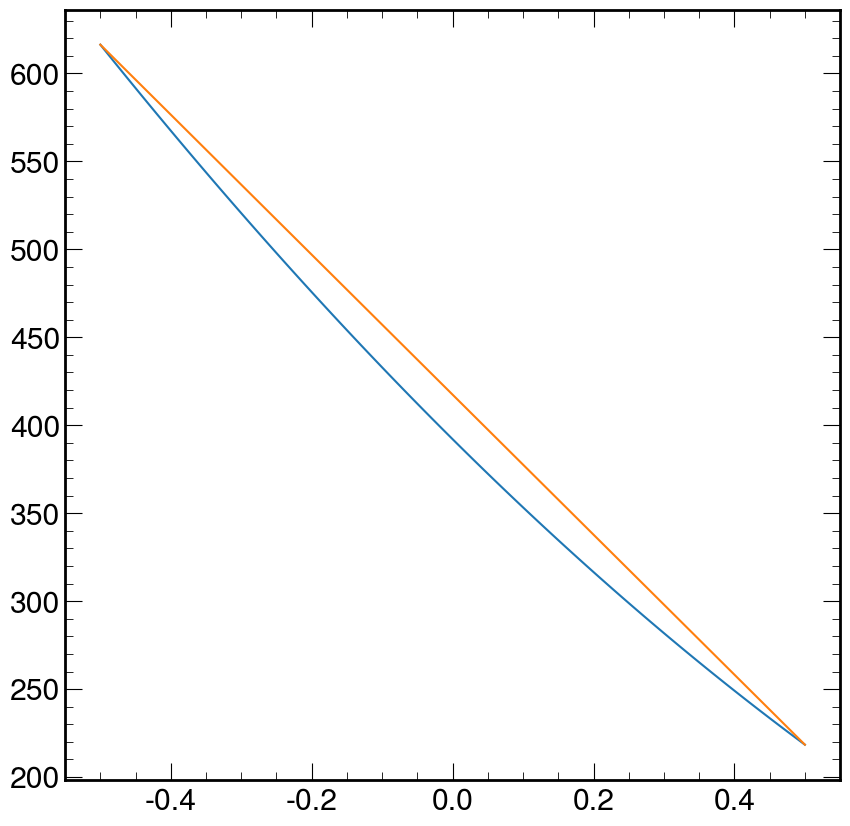

In [31]:
kZ = 2
kW_points = np.linspace(-0.5, 0.5, 101)
sig_counts = []
for kW in tqdm(kW_points):
    ST_hist = get_reco_hist(kW, kZ, "ST", np.linspace(0, 2000, 21))
    sig_counts.append(np.sum(ST_hist.counts[ST_hist.edges[:-1] >= 1700]))
    
fig, axes = plt.subplots()    
axes.plot(kW_points, sig_counts)
axes.plot(kW_points, np.linspace(np.max(sig_counts), np.min(sig_counts), 101))
axes.set_xlabel()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:23<00:00,  4.32it/s]


Text(0, 1, 'Events')

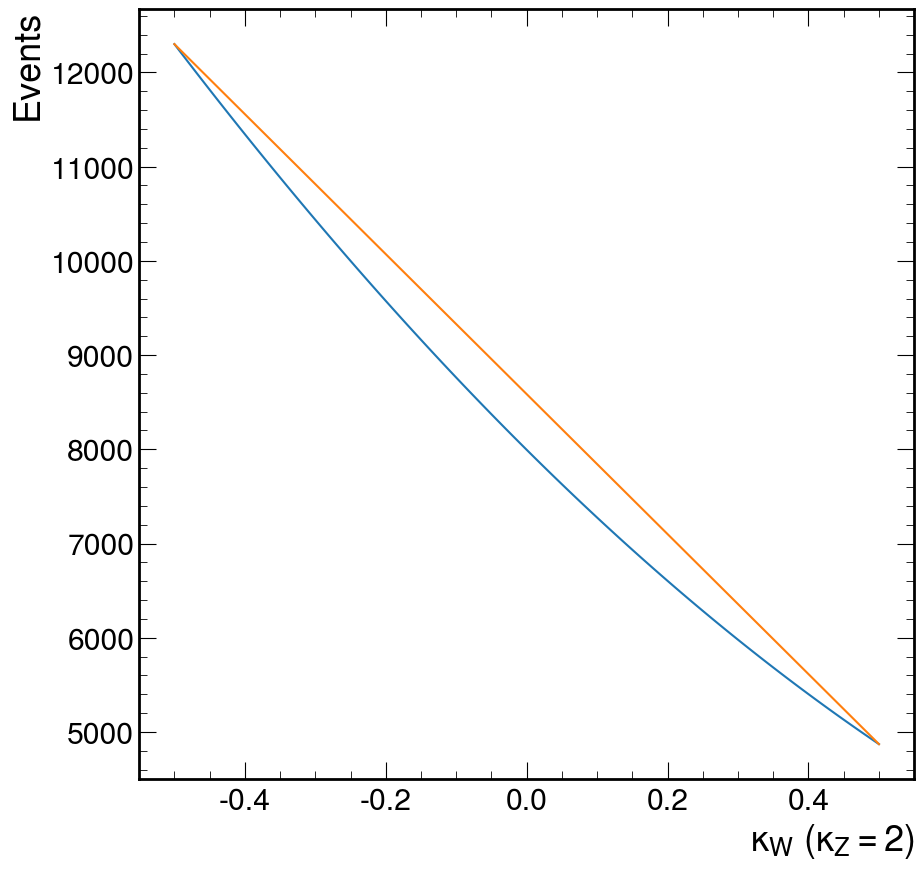

In [33]:
kZ = 2
kW_points = np.linspace(-0.5, 0.5, 101)
sig_counts = []
for kW in tqdm(kW_points):
    M_WH_hist = get_reco_hist(kW, kZ, "M_WH", np.linspace(0, 3000, 31))
    sig_counts.append(np.sum(M_WH_hist.counts[M_WH_hist.edges[:-1] >= 400]))
    
fig, axes = plt.subplots()    
axes.plot(kW_points, sig_counts)
axes.plot(kW_points, np.linspace(np.max(sig_counts), np.min(sig_counts), 101))
axes.set_xlabel(r"$\kappa_W$ $(\kappa_Z = 2)$");
axes.set_ylabel("Events")